In [1]:
%cd ..

C:\Users\310212565\Documents\repos\pscrsrn


In [45]:
import captum.attr as capa
import os
import matplotlib.collections as mplc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import yaml

In [3]:
from pscrsrn import data, rsrn

In [4]:
expt = 'experiment/2021_04_05__08_38_31'

In [5]:
with open(os.path.join(expt, 'hparams.yaml')) as f:
    hparams = yaml.safe_load(f)
hparams = hparams['model']
assert hparams['type'] == 'rsrn'
del hparams['type']

In [6]:
model = rsrn.Classify(features=1, classes=4, **hparams)
state = torch.load(
    os.path.join(expt, 'checkpoint.pt'), 
    map_location=torch.device('cpu'))
model.load_state_dict(state['model'])
model.eval()

Classify(
  (inproj_conv): Conv(
    (conv): Conv1d(1, 64, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
  )
  (inproj_norm): BatchNorm()
  (inproj_act): ReLU()
  (reduce): Reduce(
    (blocks): ModuleList(
      (0): Block(
        (conv1): Conv(
          (conv): Conv1d(65, 128, kernel_size=(5,), stride=(2,), padding=(2,))
        )
        (norm1): LayerNorm()
        (conv2): Conv(
          (conv): Conv1d(65, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (norm2): LayerNorm()
        (act): ReLU()
      )
      (1): Block(
        (conv1): Conv(
          (conv): Conv1d(65, 128, kernel_size=(5,), stride=(2,), padding=(2,))
        )
        (norm1): LayerNorm()
        (conv2): Conv(
          (conv): Conv1d(65, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (norm2): LayerNorm()
        (act): ReLU()
      )
    )
  )
  (outproj_lin1): Linear(in_features=64, out_features=64, bias=True)
  (outproj_act): ReLU()
  (outproj_lin2): Lin

In [27]:
class Wrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(torch.unbind(x))

In [28]:
wmodel = Wrapper(model)

In [9]:
d = data.Cinc2017()

In [10]:
_, dl = d(batch_size=1, trim_prob=0.0, trim_min=0.5, balanced_sampling=True)

Loading Data:   0%|          | 0/8528 [00:00<?, ?it/s]

In [11]:
xs, y = next(iter(dl))

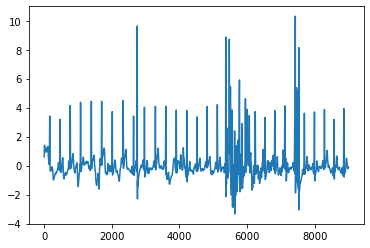

In [12]:
plt.plot(xs[0].squeeze().numpy())

In [13]:
y, d.CATS[y.item()]

(tensor([0]), 'N')

In [14]:
z = model(xs)
z, torch.softmax(z, dim=1)

(tensor([[ 1.4596, -5.3207,  1.6523, -2.4996]], grad_fn=<IndexBackward>),
 tensor([[4.4788e-01, 5.0875e-04, 5.4307e-01, 8.5445e-03]],
        grad_fn=<SoftmaxBackward>))

In [30]:
x = xs[0].unsqueeze(0)
x.requires_grad_()

tensor([[[ 0.6044],
         [ 0.7685],
         [ 0.9497],
         ...,
         [-0.1202],
         [-0.1146],
         [-0.1089]]], requires_grad=True)

In [110]:
def colorline(x, y, z, cmap=plt.get_cmap('coolwarm'), linewidth=3, alpha=1.0):
    zbound = np.max(np.abs(z))
    z /= zbound
    norm = plt.Normalize(-zbound, zbound)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = mplc.LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    ax = plt.gca()
    ax.add_collection(lc)
    return lc

In [111]:
def plot_attributions(model, x, targets, figsize=(10,10)):
    ig = capa.IntegratedGradients(model)
    x.requires_grad_()
    plt.figure(figsize=figsize)
    for target, tname in enumerate(targets):
        attr = ig.attribute(x, target=target)
        plt.subplot(len(targets), 1, target+1)
        cl = colorline(
            x = np.arange(x.shape[1]),
            y = x.detach().squeeze().numpy(),
            z = attr.detach().squeeze().numpy())
        plt.colorbar(cl)
        plt.xlim((0,x.shape[1]))
        plt.ylim((x.min().item(), x.max().item()))
        plt.title(tname)
        plt.tight_layout()

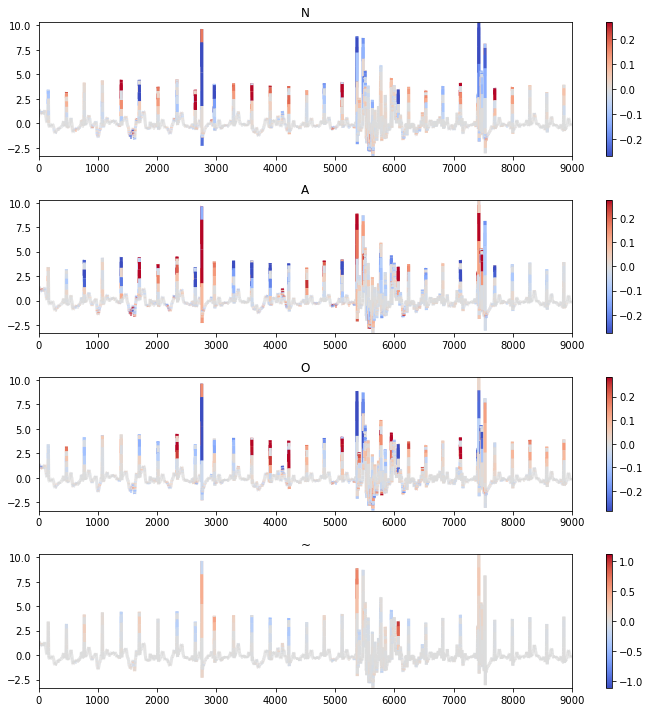

In [112]:
plot_attributions(wmodel, x, d.CATS)